In [1]:
import functools
import logging
import math
import os

In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import metadetect
import numpy as np
import galsim
from dl import queryClient as qc

In [4]:
from chromatic_weak_lensing import Darksky

In [5]:
from chromatic_shear_sims import utils
from chromatic_shear_sims.scene import Scene
from chromatic_shear_sims.psf import PSF
from chromatic_shear_sims.positions import PositionBuilder
from chromatic_shear_sims.images import ImageBuilder
from chromatic_shear_sims.data import Data
from chromatic_shear_sims.loader import Loader

from chromatic_shear_sims.galaxies import GalaxyBuilder
from chromatic_shear_sims.stars import StarBuilder, InterpolatedStarBuilder
from chromatic_shear_sims.throughputs import load_throughputs

from chromatic_shear_sims import observations

In [6]:
SEED = 1
scene_seed = utils.get_seed(seed=SEED)
star_data_seed, star_position_seed, star_rotation_seed, galaxy_data_seed, galaxy_position_seed, galaxy_rotation_seed = utils.get_seeds(6, seed=scene_seed)

In [7]:
# psf image config
PSF_XSIZE = 53
PSF_YSIZE = 53
SCALE = 0.2

# image config
XSIZE = 300
YSIZE = 300
BORDER = 50
NCOADD = 100
SCALE = 0.2

BANDS = ["g", "r", "i"]

In [8]:
sky_background = Darksky()

INFO:chromatic_weak_lensing.darksky:loading darksky from /home/smau/Documents/software/chromatic-weak-lensing/src/chromatic_weak_lensing/data/darksky.dat


In [9]:
star_builder_config = {
    "entrypoint": "chromatic_weak_lensing.btsettl:BTSettl",
}
star_kwargs = {}

star_loader_config = {
    "path": "lsst_sim",
    "predicate": [["label = 1"]],
}
star_data_config = {
    "entrypoint": "chromatic_weak_lensing.lsst_sim:LSST_Sim",
}

In [10]:
RED_LIMIT = 12_000

galaxy_builder_config = {
    "entrypoint": "chromatic_weak_lensing.diffsky:Diffsky",
    "red_limit": RED_LIMIT,
}
galaxy_kwargs = {
    "morphology": "achromatic",
}

galaxy_loader_config = {
    "path": "roman_rubin",
    "predicate": [["LSST_obs_r < 26", "LSST_obs_g < 26", "LSST_obs_i < 26"]],
}
galaxy_data_config = {
    "entrypoint": "chromatic_weak_lensing.roman_rubin:RomanRubin",
}

In [11]:
# psf config
BASE_FWHM = 0.7
BASE_WAVELENGTH = 700
ALPHA = -0.3
ZENITH_ANGLE = 0
PARALLACTIC_ANGLE = 0

psf_config = {
    "type": "ChromaticAtmosphere",
    "base_profile": {
        "type": "Gaussian",
        "fwhm": BASE_FWHM,
    },
    "base_wavelength": BASE_WAVELENGTH,
    "alpha": ALPHA,
    "zenith_angle": ZENITH_ANGLE * galsim.degrees,
    "parallactic_angle": ZENITH_ANGLE * galsim.degrees,
}

PSF_COLOR = 0.8

In [12]:
# star_position_config = {
#     "type": "none",
# }
star_position_config = {
    "type": "random",
    "n": 10,
    "xsize": XSIZE,
    "ysize": YSIZE,
    "dither": 0.5,
    "scale": SCALE,
    "border": 10,
}
galaxy_position_config = {
    "type": "hex",
    "xsize": XSIZE,
    "ysize": YSIZE,
    "separation": 10,
    "border": BORDER,
    "dither": 0.5,
    "scale": SCALE,
}

In [13]:
image_config = {
    "xsize": XSIZE,
    "ysize": YSIZE,
    "scale": SCALE,
    "ncoadd": NCOADD,
}

In [14]:
psf_image_config = {
    "xsize": PSF_XSIZE,
    "ysize": PSF_YSIZE,
    "scale": SCALE,
}

In [15]:
throughputs = load_throughputs()

INFO:chromatic_shear_sims.throughputs:loading throughput for u-band from /home/smau/Documents/software/chromatic-shear-sims/src/chromatic_shear_sims/data/total_u.dat
INFO:chromatic_shear_sims.throughputs:loading throughput for g-band from /home/smau/Documents/software/chromatic-shear-sims/src/chromatic_shear_sims/data/total_g.dat
INFO:chromatic_shear_sims.throughputs:loading throughput for r-band from /home/smau/Documents/software/chromatic-shear-sims/src/chromatic_shear_sims/data/total_r.dat
INFO:chromatic_shear_sims.throughputs:loading throughput for i-band from /home/smau/Documents/software/chromatic-shear-sims/src/chromatic_shear_sims/data/total_i.dat
INFO:chromatic_shear_sims.throughputs:loading throughput for z-band from /home/smau/Documents/software/chromatic-shear-sims/src/chromatic_shear_sims/data/total_z.dat
INFO:chromatic_shear_sims.throughputs:loading throughput for y-band from /home/smau/Documents/software/chromatic-shear-sims/src/chromatic_shear_sims/data/total_y.dat


In [16]:
psf_star_builder = InterpolatedStarBuilder(
    **star_builder_config,
    band_1="g",
    band_2="i",
)

INFO:chromatic_shear_sims.stars:made inverse lookup table in 2.339613676071167 seconds


In [17]:
psf_star = psf_star_builder(PSF_COLOR)

In [18]:
@functools.cache
def query_data_lab(ring, n):
    """Fetch TRILEGAL stars for a given ra/dec region."""
    query = \
       """SELECT mass, ra, dec, logg, logte, logl, z, mu0, av, label, c_o, gmag, rmag, imag
          FROM lsst_sim.simdr2
          WHERE (ring256={}) and label=1
          LIMIT {}
       """.format(ring, n)

    print("Submitting request:\n") 
    print(query)

    result = qc.query(sql=query, fmt="structarray")

    return result 

In [19]:
n_stars = 10
ring = 743100  # np.random.choice(range(786432))
lsst_sim_data = query_data_lab(ring, n_stars)

Submitting request:

SELECT mass, ra, dec, logg, logte, logl, z, mu0, av, label, c_o, gmag, rmag, imag
          FROM lsst_sim.simdr2
          WHERE (ring256=743100) and label=1
          LIMIT 10
       


In [20]:
star_builder = StarBuilder(
    **star_builder_config
)

In [21]:
star_loader = Loader(star_loader_config)

star_data = Data(
    **star_data_config,
    data_loader=star_loader,
)

INFO:chromatic_shear_sims.loader:initialized loader for lsst_sim with (label == 1); found 1089 rows
INFO:chromatic_shear_sims.data:initializing data for chromatic_weak_lensing.lsst_sim:LSST_Sim


In [22]:
data = {}

fn = "diffsky.testdata.hdf5"
with h5py.File(fn) as hf:
    for key in hf.keys():
        if key != "metaData":
            snap = hf[key]
            for field in snap.keys():
                if field not in data:
                    data[field] = np.array([])
                data[field] = np.append(data[field], snap[field][:])
        elif key == "metaData":
            for k, v in hf[key].items():
                print(f"{k}: {v[()]}")

H_0: 71.0
Omega_b: 0.0448
Omega_matter: 0.2648
commit_hash: b'7269934'
diffmah: b'0.4.2'
diffstar: b'0.2.2'
dsps: b'0.3.5'
healpix_cutout_number: 9043
lsstdesc_diffsky: b'0.1.6.dev51+g508b943.d20231024'
seed: 1507019545
skyArea: 3.357174580844667
versionMajor: 1
versionMinor: 0
versionMinorMinor: 0


In [23]:
galaxy_builder = GalaxyBuilder(
    **galaxy_builder_config,
)

I0000 00:00:1746485685.349439  172593 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:chromatic_weak_lensing.diffsky.utils:reading diffsky population parameters for roman_rubin_2023
INFO:chromatic_weak_lensing.diffsky.utils:loading DSPS_SSP_DATA from /home/smau/Documents/software/chromatic-weak-lensing/src/chromatic_weak_lensing/diffsky/data/dsps_ssp_data_singlemet.h5
INFO:chromatic_weak_lensing.diffsky.diffsky:discarding 1241 of 5994 wavelengths from templates


In [24]:
galaxy_loader = Loader(galaxy_loader_config)

galaxy_data = Data(
    **galaxy_data_config,
    data_loader=galaxy_loader,
)

INFO:chromatic_shear_sims.loader:initialized loader for roman_rubin with (((LSST_obs_r < 26) and (LSST_obs_g < 26)) and (LSST_obs_i < 26)); found 1132558 rows
INFO:chromatic_shear_sims.data:initializing data for chromatic_weak_lensing.roman_rubin:RomanRubin


In [25]:
star_position_builder = PositionBuilder.from_config(star_position_config)
star_positions = star_position_builder.get_positions(seed=star_position_seed)
star_rotations = star_position_builder.get_rotations_for(star_positions, seed=star_rotation_seed)

In [26]:
galaxy_position_builder = PositionBuilder.from_config(galaxy_position_config)
galaxy_positions = galaxy_position_builder.get_positions(seed=galaxy_position_seed)
galaxy_rotations = galaxy_position_builder.get_rotations_for(galaxy_positions, seed=galaxy_rotation_seed)

In [27]:
stars = star_data.load(len(star_positions), seed=star_data_seed)

INFO:chromatic_shear_sims.loader:sampled 10 records from lsst_sim in 0.009352922439575195 seconds


In [28]:
scene_stars = [
    star_builder(stars.get_params(i), **star_kwargs).rotate(
        rotation
    ).shift(position)
    for i, (position, rotation) in enumerate(
        zip(star_positions, star_rotations)
    )
]

In [29]:
galaxies = galaxy_data.load(len(galaxy_positions), seed=galaxy_data_seed)

INFO:chromatic_shear_sims.loader:sampled 19 records from roman_rubin in 1.024618148803711 seconds


In [30]:
scene_galaxies = [
    galaxy_builder(
        galaxies.get_params(i),
        **galaxy_kwargs,
    ).rotate(
        rotation
    ).shift(position)
    for i, (position, rotation) in enumerate(
        zip(galaxy_positions, galaxy_rotations)
    )
]

In [31]:
scene = Scene(galaxies=scene_galaxies, stars=scene_stars)

In [32]:
image_builder = ImageBuilder.from_config(image_config)
psf_image_builder = ImageBuilder.from_config(psf_image_config)

In [33]:
psf = PSF(psf_config)

In [34]:
mbobs = observations.get_mbobs(
    BANDS,
    throughputs,
    psf,
    scene,
    # psf_star,
    # psf_image_builder=psf_image_builder,
    image_builder=image_builder,
    sky_background=sky_background,
    seed=scene_seed,
)

INFO:chromatic_weak_lensing.darksky:computed noise standard deviation 3.2325103879685164e-08 flux per pixel
INFO:chromatic_shear_sims.observations:drew 19 galaxies in 1.233428955078125 seconds
INFO:chromatic_shear_sims.observations:drew 10 stars in 0.5289263725280762 seconds
INFO:chromatic_shear_sims.observations:made g-band observation in 2.4323887825012207 seconds
INFO:chromatic_weak_lensing.darksky:computed noise standard deviation 4.761068233293641e-08 flux per pixel
INFO:chromatic_shear_sims.observations:drew 19 galaxies in 1.6212172508239746 seconds
INFO:chromatic_shear_sims.observations:drew 10 stars in 0.5207428932189941 seconds
INFO:chromatic_shear_sims.observations:made r-band observation in 2.177593231201172 seconds
INFO:chromatic_weak_lensing.darksky:computed noise standard deviation 5.8228218784810457e-08 flux per pixel
INFO:chromatic_shear_sims.observations:drew 19 galaxies in 1.9691262245178223 seconds
INFO:chromatic_shear_sims.observations:drew 10 stars in 0.54851603507

In [35]:
psf_mbobs = observations.get_psf_mbobs(
    BANDS,
    throughputs,
    psf,
    psf_star,
    psf_image_builder,
    seed=None,
)

INFO:chromatic_shear_sims.observations:made g-band psf observation in 0.08018374443054199 seconds
INFO:chromatic_shear_sims.observations:made r-band psf observation in 0.07551908493041992 seconds
INFO:chromatic_shear_sims.observations:made i-band psf observation in 0.08159995079040527 seconds
INFO:chromatic_shear_sims.observations:made gri-multiband psf observation in 0.23905229568481445 seconds


In [36]:
mbobs = observations.with_psf_obs(mbobs, psf_mbobs)

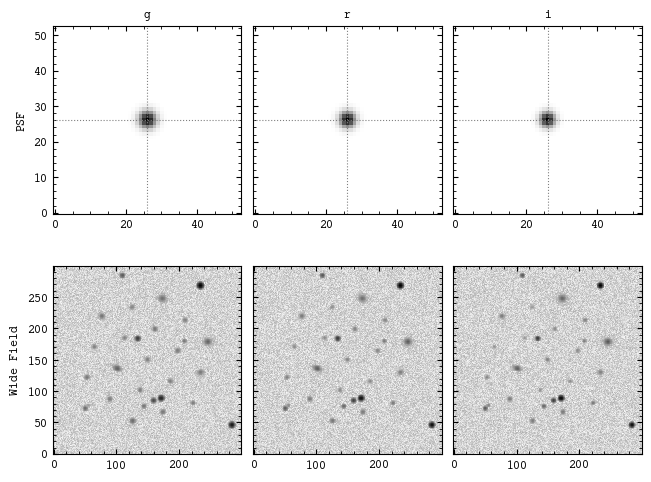

In [37]:
fig, axs = plt.subplots(
    2, len(BANDS),
    sharex="row",
    sharey="row",
    constrained_layout=True,
)

norm_field = mpl.colors.Normalize()

for i, band in enumerate(BANDS):
    obs = mbobs[i][0]
    image = obs.image
    psf_image = obs.psf.image
    noise_image = obs.noise
    weight_image = obs.weight
    
    axs[0, i].imshow(psf_image, origin="lower")
    axs[0, i].axvline((psf_image.shape[0] - 1) / 2, c="gray", ls=":")
    axs[0, i].axhline((psf_image.shape[1] - 1) / 2, c="gray", ls=":")

    # axs[1, i].imshow(image, origin="lower", norm=norm_field)
    axs[1, i].imshow(np.arcsinh(image * np.sqrt(weight_image)), origin="lower", norm=norm_field)
    # axs[1, i].imshow(np.arcsinh(image / np.sqrt(np.var(noise_image))), origin="lower", norm=norm_field)
    
    axs[0, i].set_title(band)

axs[0, 0].set_ylabel("PSF")
axs[1, 0].set_ylabel("Wide Field")

plt.show()

In [38]:
mdet_rng = np.random.default_rng(
    utils.get_seed(seed=SEED)
)
metadetect_config = {
    "model": "pgauss",
    "weight": {
        "fwhm": 2.0,
    },
    "symmetrize": False,
    "metacal": {
        "psf": "fitgauss",
        "types": ["noshear", "1p", "1m", "2p", "2m"],
        "use_noise_image": True,
    },
    "meds": {
        "box_padding": 2,
        "box_type": "iso_radius",
        "max_box_size": 48,
        "min_box_size": 48,
        "rad_fac": 2,
        "rad_min": 4,
    },
}

res = metadetect.do_metadetect(
    metadetect_config,
    mbobs,
    mdet_rng,
)

INFO:metadetect.metadetect:computing mbobs data: None [0, 1, 2]
INFO:metadetect.metadetect:set mbobs data caches
INFO:metadetect.metadetect:key None not in mbobs data cache
INFO:metadetect.metadetect:PSF fits took 2.153102397918701 seconds
INFO:metadetect.metadetect:metacal took 1.3324720859527588 seconds
INFO:metadetect.metadetect:shear_bands key (0, 1, 2) not in mbobs data cache
INFO:metadetect.metadetect:computing mbobs data: None [0, 1, 2]
INFO:metadetect.metadetect:detect took 0.04857134819030762 seconds
INFO:metadetect.metadetect:fitter pgauss took 3.551654100418091 seconds
INFO:metadetect.metadetect:src measurements took 3.5530190467834473 seconds
INFO:metadetect.metadetect:detect took 0.045896291732788086 seconds
INFO:metadetect.metadetect:fitter pgauss took 0.4993579387664795 seconds
INFO:metadetect.metadetect:src measurements took 1.0931544303894043 seconds
INFO:metadetect.metadetect:detect took 0.04403543472290039 seconds
INFO:metadetect.metadetect:fitter pgauss took 0.48740

In [39]:
model = metadetect_config["model"]
if model == "wmom":
    tcut = 1.2
else:
    tcut = 0.5

s2n_cut = 10
# t_ratio_cut = tcut
# mfrac_cut = 10
# s2n_cut = 0
t_ratio_cut = 0
mfrac_cut = 0
ormask_cut = None

def _mask(data):
    if "flags" in data.dtype.names:
        flag_col = "flags"
    else:
        flag_col = model + "_flags"

    _cut_msk = (
        (data[flag_col] == 0)
        & (data[model + "_s2n"] > s2n_cut)
        & (data[model + "_T_ratio"] > t_ratio_cut)
    )
    if ormask_cut:
        _cut_msk = _cut_msk & (data["ormask"] == 0)
    if mfrac_cut is not None:
        _cut_msk = _cut_msk & (data["mfrac"] <= mfrac_cut)
    return _cut_msk

o = res["noshear"]
q = _mask(o)

ns = o[q]


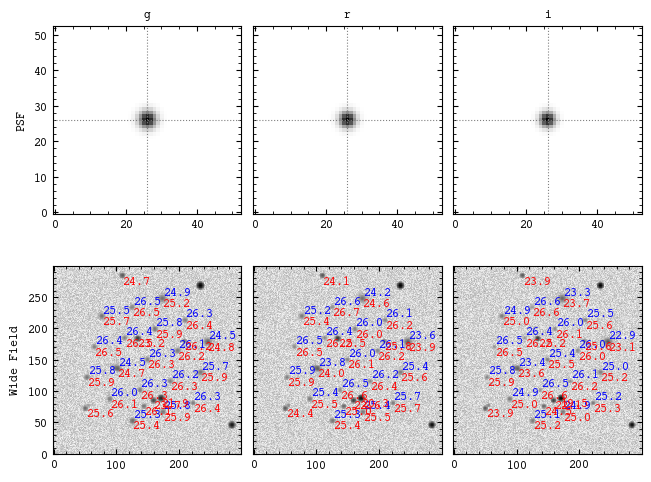

In [40]:
fig, axs = plt.subplots(
    2, len(BANDS),
    sharex="row",
    sharey="row",
    constrained_layout=True,
)

norm_field = mpl.colors.Normalize()

for i, band in enumerate(BANDS):
    obs = mbobs[i][0]
    image = obs.image
    psf_image = obs.psf.image
    noise_image = obs.noise
    weight_image = obs.weight
    
    axs[0, i].imshow(psf_image, origin="lower")
    axs[0, i].axvline((psf_image.shape[0] - 1) / 2, c="gray", ls=":")
    axs[0, i].axhline((psf_image.shape[1] - 1) / 2, c="gray", ls=":")

    # axs[1, i].imshow(image, origin="lower", norm=norm_field)
    axs[1, i].imshow(np.arcsinh(image * np.sqrt(weight_image)), origin="lower", norm=norm_field)
    # axs[1, i].imshow(np.arcsinh(image / np.sqrt(np.var(noise_image))), origin="lower", norm=norm_field)

    # true
    for galaxy in scene.galaxies:
        center = image_builder.get_image().true_center
        centroid = galaxy.calculateCentroid(throughputs[band]) / SCALE + center
        mag = galaxy.calculateMagnitude(throughputs[band])
        axs[1, i].text(centroid.x, centroid.y, round(mag, 1), c="b", ha="left", va="bottom")

    # detected
    for j in range(len(ns)):
        x = ns["sx_col"][j]
        y = ns["sx_row"][j]
        flux = ns["pgauss_band_flux"][j][i]
        s2n = ns[model + "_s2n"][j]
        zp = throughputs[band].zeropoint
        mag = -2.5 * np.log10(flux) + zp
        axs[1, i].text(x, y, round(mag, 1), c="r", ha="left", va="top")
    
    axs[0, i].set_title(band)

axs[0, 0].set_ylabel("PSF")
axs[1, 0].set_ylabel("Wide Field")

plt.show()